In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from sympy import S, symbols, printing

from compilers import * 
from utils import *

import json

## Hamiltonian Initialization



This section handles initialization of specific Hamiltonians and simulation parameters.

#### Arbitrary Tensored 4x4 Pauli

In [2]:
X = np.array([[0, 1],
     [1, 0]])
Z = np.array([[1, 0],
     [0, -1]])
Y = np.array([[0, -1j],
     [1j, 0]])
I = np.array([[1, 0],
     [0, 1]])
XX = np.kron(X, X) #tensor products between two Pauli's
XZ = np.kron(X, Z)
ZZ = np.kron(Z, Z)
ZX = np.kron(Z, X)
II = np.kron(I, I)
IX = np.kron(I, X)
XI = np.kron(X, I)
IZ = np.kron(I, Z)
ZI = np.kron(Z, I)
#List of Hamiltonian decomposition terms H_j for H = \sum_j h_j H_j
Hlist = np.array([XX, XZ, ZX, ZZ, IX, IZ, XI, ZI])
hj = [1.0, 2.0, -3.0, -4.0, -2.0, 1.0, 0.5, 0.25] #list of normalized coefficients

print(Hlist.shape)

hamiltonian_list = []
for i in range(len(hj)):
    hamiltonian_list.append(hj[i] * Hlist[i, :, :])
hamiltonian_list = np.array(hamiltonian_list)
pauli_hamiltonian = hamiltonian_list
print(hamiltonian_list.shape)
#print(hamiltonian_list)

(8, 4, 4)
(8, 4, 4)


### Graph Hamiltonians

In [3]:
# A simple function that computes the graph distance between two sites
def dist(site1, site2):
    distance_vec = site1 - site2
    distance = np.abs(distance_vec[0]) + np.abs(distance_vec[1])
    return distance

# A simple function that initializes a graph in the form of an np.array of coordinates 
def initialize_graph(x_sites, y_sites):
    coord_list = []
    for i in range(x_sites):
        for j in range(y_sites):
            coord_list.append([i,j])
    return np.array(coord_list)

#A funciton that initializes a Pauli operator in the correct space, acting on a specific qubit
def initialize_operator(operator_2d, acting_space, space_dimension):
    if acting_space>space_dimension:
        return 'error'
    for i in range(acting_space):
        operator_2d = np.kron(operator_2d, I)
    for j in range(space_dimension - acting_space-1):
        operator_2d = np.kron(I, operator_2d)
    return operator_2d

##### Exponentially Decaying Interaction (Quasi-Local)

In [4]:
#Initialize Hamiltonian 
def graph_hamiltonian(x_dim, y_dim, rng_seed):
    np.random.seed(rng_seed)
    hamiltonian_list = []
    graph = initialize_graph(x_dim, y_dim)
    for i in range(x_dim*y_dim):
        for j in range(y_dim*x_dim):
            if i != j: #long range interaction
                alpha = np.random.normal()
                hamiltonian_list.append(alpha * 
                    np.matmul(initialize_operator(Z, i, x_dim*y_dim), initialize_operator(Z, j, x_dim*y_dim)) *
                        10.0**(-dist(graph[i], graph[j]))) 

            # if (dist(graph[i], graph[j])==1) and (i>j): #nearest neighbour interaction
            #     beta = np.random.normal()
            #     hamiltonian_list.append(beta * np.matmul(initialize_operator(Y, i, x_dim*y_dim), initialize_operator(Y, j, x_dim*y_dim)))
            
        gamma = np.random.normal()
        hamiltonian_list.append(4* gamma * initialize_operator(X, i, x_dim*y_dim))
                
    return np.array(hamiltonian_list)

#### Local Heisenberg Model

In [5]:
#a function that generates the list of hamiltonian terms for a random NN Heinsenberg model with abritrary b_field strength
def heisenberg_hamiltonian(length, b_field, rng_seed):
    y_dim = 1
    x_dim = length #restrict to 1d spin change so we can get more disjoint regions
    np.random.seed(rng_seed)
    hamiltonian_list = []
    indices = []
    #graph = initialize_graph(x_dim, y_dim)
    operator_set = [X, Y, Z]
    lat_points = x_dim*y_dim
    for k in operator_set:
        for i in range(lat_points):
            for j in range (lat_points):
                if (i == j+1):
                    alpha = np.random.normal()
                    hamiltonian_list.append(2**alpha * np.matmul(initialize_operator(k, i, lat_points), initialize_operator(k, j, lat_points)))
                    indices.append([i, j])

                #if ((i==0) and (j==lat_points-1)): #periodic BC (we dont want this as we want to limit connectivity) 
                    #alpha = np.random.normal()
                    #hamiltonian_list.append(10**alpha * np.matmul(initialize_operator(k, i, lat_points), initialize_operator(k, j, lat_points)))

            if np.array_equal(Z, k) == True:
                #beta = np.random.normal() if we want to randomize the field strength reponse at each site (might be unphysical)
                hamiltonian_list.append(b_field * initialize_operator(k, i, lat_points))
                indices.append([i])

    return (np.array(hamiltonian_list) , indices, length)

#### Thesis Cost Plots

In [6]:
# #local
# heisenberg_hamiltonian_list = heisenberg_hamiltonian(length = 7, b_field=1, rng_seed=1)
# local_hamiltonian_list = hamiltonian_localizer_1d(heisenberg_hamiltonian_list, sub_block_size=3)
# normalized_heisenberg = normalize_hamiltonian(heisenberg_hamiltonian_list[0])
# print("local model shape: " + str(heisenberg_hamiltonian_list[0].shape))

# local_sim = LRsim(heisenberg_hamiltonian_list[0], local_hamiltonian_list, inner_order=1, nb=[1,1,1], state_rand = False)
# local_trot =  LRsim(heisenberg_hamiltonian_list[0], local_hamiltonian_list, inner_order=1, nb=[1,1,1], state_rand = False)
# trotter1 = CompositeSim(normalized_heisenberg, inner_order=1, outer_order=1, nb=1, state_rand=False, exact_qd=True, use_density_matrices=True)
# trotter2 = CompositeSim(normalized_heisenberg, inner_order=2, outer_order=1, nb=1, state_rand=False, exact_qd=True, use_density_matrices=True)
# qdrift = CompositeSim(normalized_heisenberg, inner_order=1, outer_order=1, nb=1, state_rand=False, exact_qd=True, use_density_matrices=True)

In [7]:
#non-local
graph_hamiltonian_list = graph_hamiltonian(7, 1, 1)
print("graph hamiltonian shape: " +str(graph_hamiltonian_list.shape))
sim = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, nb=1, state_rand=True, exact_qd=True, use_density_matrices=True)
trotter1 = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, nb=1, state_rand=True, exact_qd=True, use_density_matrices=True)
trotter2 = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, nb=1, state_rand=True, exact_qd=True, use_density_matrices=True)
qdrift = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, nb=1, state_rand=True, exact_qd=True, use_density_matrices=True)
# if np.array_equal(sim.initial_state, trotter1.initial_state) == True:
#     print("yes!")

graph hamiltonian shape: (49, 128, 128)


In [8]:
#time evolution
t_i = 0.05
t_f=1.75
t_steps = 20
times = np.geomspace(t_i, t_f, t_steps)
epsilon=0.001
print(times)

[0.05       0.06028881 0.07269482 0.08765369 0.10569075 0.12743939
 0.1536634  0.18528368 0.22341067 0.26938329 0.32481599 0.39165541
 0.47224881 0.56942642 0.68660088 0.82788706 0.99824658 1.20366206
 1.45134717 1.75      ]


In [9]:
CompSim_results = dict()
local_trot_results = dict()
TrotSim1_results = dict()
TrotSim2_results = dict()
QDSim_results = dict()

#local_partition(local_trot, "trotter")
partition_sim(trotter1, "trotter")
partition_sim(trotter2, "trotter")

for t in times:
    #local_partition(local_sim, "optimal_chop", time=t, epsilon=epsilon)
    #CompSim_results[t] = int(local_sim.gate_count)
    #local_trot_results[t] = int(exact_cost(local_trot, time=t, nb=[1,1,1], epsilon=epsilon))
    partition_sim(sim, "exact_optimal_chop", time =t, epsilon=epsilon)
    CompSim_results[t] = int(sim.gate_count)

    TrotSim1_results[t] = int(exact_cost(trotter1, time=t, nb=1, epsilon=epsilon))

    TrotSim2_results[t] = int(exact_cost(trotter2, time=t, nb=1, epsilon=epsilon))
    

Iteration No: 1 started. Evaluating function at provided point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 7.8996
Function value obtained: 222.0000
Current minimum: 222.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 67.5190
Function value obtained: 343.0000
Current minimum: 222.0000
Iteration No: 3 started. Evaluating function at random point.


ValueError: Expecting at least two arrays.

In [9]:
QDSim_results.clear()
times = np.geomspace(t_i, t_f, t_steps)
qd_times = times[:15]
partition_sim(qdrift, "qdrift")
for t in qd_times:
    QDSim_results[t] = int(exact_cost(qdrift, time=t, nb=1, epsilon=epsilon))

[sim_channel_performance] Iterations too large, already below error threshold


In [10]:
outfile = open("(7,1) graph, rand_states, chop1, trot1, trot2, qd", "w")
json.dump(CompSim_results, outfile)
json.dump(TrotSim1_results, outfile)
json.dump(TrotSim2_results, outfile)
#json.dump(local_trot_results, outfile)
json.dump(QDSim_results, outfile)
outfile.close()

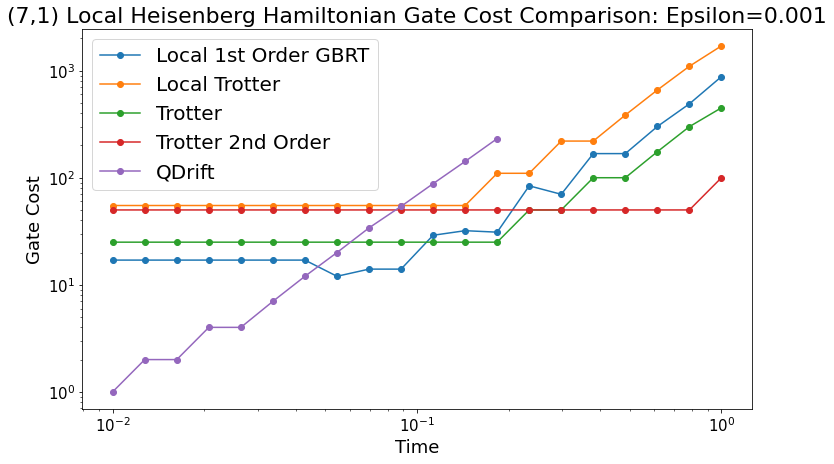

In [12]:
#plotting
plt.figure(figsize = (12, 7))
plt.title("(7,1) Local Heisenberg Hamiltonian Gate Cost Comparison: Epsilon=0.001", size =22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Time", size =18)
plt.ylabel("Gate Cost", size =18)
plt.loglog(times, list(CompSim_results.values()), "o-", label="1st Order GBRT")
#plt.loglog(times, list(local_trot_results.values()), "o-", label="Local Trotter")
plt.loglog(times, list(TrotSim1_results.values()), "o-",label="Trotter")
plt.loglog(times, list(TrotSim2_results.values()),"o-", label="Trotter 2nd Order")
plt.loglog(qd_times, list(QDSim_results.values()), "o-",label="QDrift")
plt.legend(fontsize = 20)
plt.show()

#### Thesis Scaling Figures

In [6]:
graph_hamiltonian_list = graph_hamiltonian(6, 1, 1)
print(graph_hamiltonian_list.shape)
heisenberg_hamiltonian_list = heisenberg_hamiltonian(6, 0.5, rng_seed=1)
local_hamiltonian_list = hamiltonian_localizer_1d(heisenberg_hamiltonian_list, 2)
print(local_hamiltonian_list[0].shape)

sim = CompositeSim(graph_hamiltonian_list, inner_order=4, outer_order=1, nb=1, state_rand=True, exact_qd=True, use_density_matrices=True)
partition_sim(sim, "trotter", chop_threshold=0.005)
print(len(sim.trotter_norms),len(sim.qdrift_norms))

local_sim = LRsim(heisenberg_hamiltonian_list[0], local_hamiltonian_list, inner_order=2, nb=[1,1,1], state_rand = True)
local_partition(local_sim, "chop", weights=[0.01, 0.01, 0.01]) ###need to normalize the list of spectral norms
#print("optimal gate: " +str(local_sim.gate_count))
#print(local_sim.nb)

#print(len(local_hamiltonian_list[0]))
#print(len(local_hamiltonian_list[1]))
#print(len(local_hamiltonian_list[2]))

tstart = 0.0005
tfinal = 0.1
tsteps = 20
times = np.geomspace(tstart, tfinal, tsteps)
#print(multi_infidelity_sample(sim, 1, exact_time_evolution_density(sim.unparsed_hamiltonian, 1, sim.initial_state), 40, 20))
epsilon_data=[]
for t in times:
    epsilon_data.append(sim_trace_distance(sim, time=t, iterations=1, nb=2))
    #inf_list, _ = zip(*multi_infidelity_sample(sim, t, exact_time_evolution(sim.unparsed_hamiltonian, t, sim.initial_state), iterations=1, nbsamples=1, mc_samples=1))
    #epsilon_data.append(statistics.mean(inf_list))

exact_cost(sim, time = 0.005, nb=1, epsilon=0.001) #should set the gate count to zero or refresh them somewhere 

(36, 64, 64)
(16, 64, 64)
36 0
block 0 has 16 trotter terms and 0 qdrift terms
block 1 has 11 trotter terms and 0 qdrift terms
block 2 has 16 trotter terms and 0 qdrift terms
[sim_channel_performance] Iterations too large, already below error threshold


360

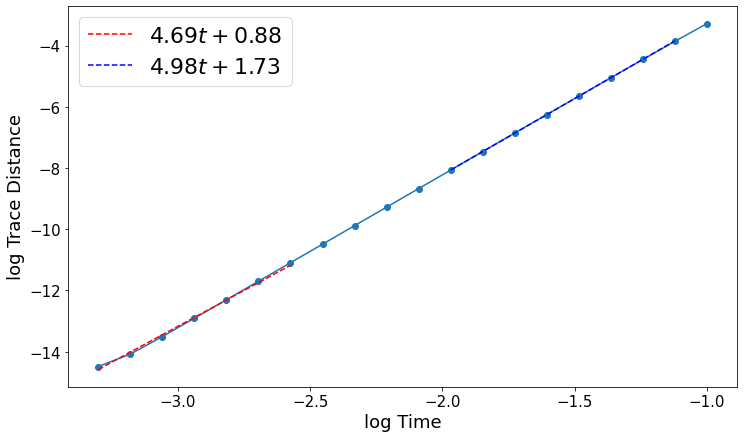

In [9]:
data = np.log10(epsilon_data)
log_times = np.log10(times)
plt.figure(figsize = (12, 7))
plt.plot(log_times, data, 'o-') 
plt.xlabel('log Time', size = 18)
plt.ylabel('log Trace Distance', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

start_fit_points= 0 #declare the starting point to fit in the data
end_fit_points = -14

p = np.polyfit(log_times[start_fit_points: end_fit_points], data[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)
plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize= 22)

data = np.log10(epsilon_data)
start_fit_points1= 11 #declare the starting point to fit in the data
end_fit_points1 = -2
p1 = np.polyfit(log_times[start_fit_points1: end_fit_points1], data[start_fit_points1: end_fit_points1], 1)
f1 = np.poly1d(p1)

t_new1 = np.linspace(log_times[start_fit_points1], log_times[end_fit_points1], 50)
y_new1 = f1(t_new1)

data = symbols("t")
poly1 = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p1[::-1]))
eq_latex1 = printing.latex(poly1)

plt.plot(t_new1, y_new1, 'b--', label="${}$".format(eq_latex1))
plt.legend(fontsize= 22)
plt.show()

In [11]:
#LR Sim example 
#seems to work, gbrt requires exact density here
local_nb = [2, 2, 2]
heisenberg_hamiltonian_list = heisenberg_hamiltonian(8, 0.5, rng_seed=1)
print(heisenberg_hamiltonian_list[0].shape)
local_hamiltonian = hamiltonian_localizer_1d(heisenberg_hamiltonian_list, sub_block_size=2)
print(len(local_hamiltonian[0]))
print(len(local_hamiltonian[1]))
print(len(local_hamiltonian[2]))

local_hamiltonian = LRsim(heisenberg_hamiltonian_list[0], local_hamiltonian, inner_order = 1, nb = local_nb, state_rand = False)

local_partition(local_hamiltonian, partition = "trotter", time= 0.01, epsilon = 0.01)

final_state = local_hamiltonian.simulate(time = 0.05, iterations = 4)

print('total gate count ' +str(local_hamiltonian.gate_count))
exact_cost(local_sim, time = 0.0001, nb=local_nb, epsilon=0.001)

(29, 256, 256)
20
11
20
total gate count 204
[sim_channel_performance] Iterations too large, already below error threshold


43

### OpenFermion Hamiltonian List Generators

In [6]:
from openfermion.hamiltonians import jellium_model
from openfermion.utils import Grid, count_qubits
from openfermion.transforms import jordan_wigner, fourier_transform, get_fermion_operator
from openfermion.linalg import eigenspectrum, qubit_operator_sparse, get_sparse_operator
from openfermion.ops import QubitOperator

#A function to help convert from the default output of openfermion to the style we require to run our simulator, 
# a numpy array that is structured as a list of hamiltonian terms. 
def openfermion_matrix_list(qubit_operator):
    total_qubits = count_qubits(qubit_operator)
    matrix_list = []
    op_list = list(qubit_operator)
    for i in op_list:
        matrix_list.append(get_sparse_operator(i, total_qubits).toarray()) #changed from qubit operator and made no differnce
    return np.array(matrix_list)

    #Test -- shows ops are equivalent
def test_list_generator(openfermion_output):
    max_val = []
    of_generator = get_sparse_operator(openfermion_output).toarray()
    list_generator = sum(openfermion_matrix_list(openfermion_output))
    the_zero_op = of_generator - list_generator
    for i in range(the_zero_op.shape[0]):
        for j in range(the_zero_op.shape[0]):
            max_val.append((the_zero_op)[i][j])
    print(max(max_val))
    norm = np.linalg.norm(the_zero_op, ord=2)
    if norm < FLOATING_POINT_PRECISION:
        print("success!")
    else:
        print("failed!")
    return 0

#### Jellium

In [7]:
#small model in 2 dimensions
grid = Grid(dimensions=1, length=5, scale=1.0)
spinless = True

# Get the momentum Hamiltonian.
momentum_hamiltonian = jellium_model(grid, spinless)
momentum_qubit_operator = jordan_wigner(momentum_hamiltonian)
momentum_qubit_operator.compress()

#Generate the matrix list
jellium_hamiltonian_list = openfermion_matrix_list(momentum_qubit_operator) #load this into simulator
print(jellium_hamiltonian_list)
print(momentum_qubit_operator)
test_list_generator(momentum_qubit_operator)

[[[ 9.81986848e+01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  9.81986848e+01+0.j  0.00000000e+00+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j  9.81986848e+01+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  ...
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
    9.81986848e+01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
    0.00000000e+00+0.j  9.81986848e+01+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  9.81986848e+01+0.j]]

 [[-3.92794739e+01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
    0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
  [ 0.00000000e+00+0.j -3.92794739e+01+0.j  0.00000000e+00+0.j ...
    0.00

0

#### LiH, Methane, and Ethane

In [8]:
from openfermion.chem import geometry_from_pubchem
from openfermion.chem import MolecularData

basis = 'sto-3g'
multiplicity = 1

# Set Hamiltonian parameters.
active_space_start = 1
active_space_stop = 4

In [9]:
#LiH
#LiH_geometry = geometry_from_pubchem('LiH')
diatomic_bond_length = 1.45
LiH_geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
print(LiH_geometry)

# Generate and populate instance of MolecularData.
LiH_molecule = MolecularData(LiH_geometry, basis, multiplicity, description="1.45")
LiH_molecule.load()

# Get the Hamiltonian in an active space.
LiH_molecular_hamiltonian = LiH_molecule.get_molecular_hamiltonian(
    occupied_indices=range(active_space_start),
    active_indices=range(active_space_start, active_space_stop))

# Map operator to fermions and qubits.
LiH_fermion_hamiltonian = get_fermion_operator(LiH_molecular_hamiltonian)
LiH_qubit_hamiltonian = jordan_wigner(LiH_fermion_hamiltonian)
LiH_hamiltonian_list = openfermion_matrix_list(LiH_qubit_hamiltonian)
print(LiH_hamiltonian_list.shape)
#print(list(LiH_qubit_hamiltonian))
#print(LiH_hamiltonian_list)
test_list_generator(LiH_qubit_hamiltonian)

[('Li', (0.0, 0.0, 0.0)), ('H', (0.0, 0.0, 1.45))]
(62, 64, 64)
(8.881784197001252e-16+0j)
success!


0

# TODO
- time scale plots infidelity vs time (keep iterations fixed)
- trace distance vs time (iterations fixed)
- Gate counts vs time (vary iterations) to hit inf threshold
- Will need to handle partitioning across times
- 

# Performance Checks
In this section we want to make sure that our simulators are performing consistently with predicted results from theory. We use a Hamiltonian consisting of two pauli operators tensor producted together. The three things we are looking for are infidelity, trace distance, and gate cost performance. Each of these is explained in greater detail below. Across all three we will use a small random sampling of input states and analyze the averages.

### Prep

[CompositeSim] # of Trotter terms: 8 , # of Qdrift terms:  0 , and Nb =  1
[CompositeSim] # of Trotter terms: 0 , # of Qdrift terms:  8 , and Nb =  1


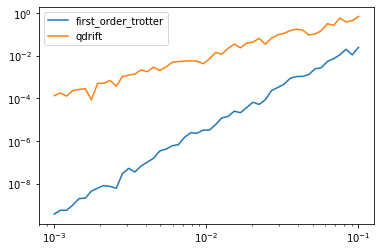

[CompositeSim] # of Trotter terms: 8 , # of Qdrift terms:  0 , and Nb =  1


KeyboardInterrupt: 

In [4]:
iterations = 1
times = np.geomspace(0.01, 0.5, 50)

first_order_trott_sim = CompositeSim(hamiltonian_list=hamiltonian_list, inner_order=1)
partition_sim(first_order_trott_sim, "trotter")

second_order_trott_sim = CompositeSim(hamiltonian_list=hamiltonian_list, inner_order = 2)
partition_sim(second_order_trott_sim, "trotter")

qdrift_sim = CompositeSim(hamiltonian_list=hamiltonian_list)
partition_sim(qdrift_sim, "qdrift")

comp_sim = CompositeSim(hamiltonian_list=hamiltonian_list)

def test_performance(
        simulator,
        t_start=1e-3,
        t_end=1e-1,
        t_steps=50,
        num_state_samples=5,
        partitions=["first_order_trotter", "qdrift"],
        performance="infidelity",
        infidelity_threshold=0.05
    ):
    times = np.geomspace(t_start, t_end, t_steps)
    results = dict()
    for partition in partitions:
        vals = []
        partition_sim(simulator, partition_type=partition)
        simulator.print_partition()
        heuristic = -1
        for t in times:
            val = 0
            for _ in range(num_state_samples):
                simulator.randomize_initial_state()
                if performance == "infidelity":
                    inf_temp, _ = single_infidelity_sample(simulator, t)
                    val += inf_temp
                elif performance == "gate_cost":
                    cost, iters = find_optimal_cost(simulator, t, infidelity_threshold, heuristic=heuristic)
                    heuristic = iters
                    val += cost

            vals.append(val / num_state_samples)
        results[partition] = vals
    results["times"] = times
    for partition, vals in results.items():
        if partition != "times":
            plt.loglog("times", partition, data=results, label=partition)
    plt.legend()
    plt.show()
    

test_performance(comp_sim)
test_performance(comp_sim,t_start=1e-6, t_end=1e-1, performance="gate_cost")

## Infidelity Performance
This section compares that our compilers match theoretic predictions for infidelity scaling with respect to time. We keep iterations fixed and compare how the different compilers perform. We will use a simple kronecker product of pauli matrices for baseline testing. For the composite simulation testing we will use the probabilistic partitioning scheme and repartition at each time step with the goal of observing a transition from QDrift to Trotter scaling. 

- What do we do about inputs?

## Trace Distance Performance
This section is similar to the prior, we keep the number of iterations fixed and instead evaluate the Trace Distance.

## Gate Count Performance
We now compare how the gate count of each partitioning type varies across time while each simulator meets a specified threshold in infidelity. In this we search for the smallest number of iterations that meet the infidelity threshold, the iterations then determines the gate count. 

# Partitioning Performance
In this section we look at the relative performance of each type of partitioning, including Trotter and QDrift only partitions, with more involved Hamiltonians. This includes simulations that take a relatively long time to compute. 

## Notebook using compilers.py

The goal is to compare the functions in compilers.py in both output and runtimes. The only part of the previous sections that this section will reference is "Hamiltonian Initialization"

In [13]:
#Load sims and test Monte-Carlo
CompSim1 = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, initial_time=0.1, partition="prob", nb = 10, nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)
TrotSim1 = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="trotter", nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)
TrotSim2 = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, partition="trotter", nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)
QDSim1  = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="qdrift", nb_optimizer=False, weight_threshold=0.5, epsilon=0.05)

t = 0.1
samples = 120
iterations = 1
sample_guess = 4
mcsamples = 200
#mcsamples = QDSim1.sample_decider(t, samples, iterations, sample_guess) #needs to be evaluated in a region known to be convergent
print(mcsamples)

Nb is 16
There are 12 terms in Trotter
There are 13 terms in QDrift
There are 25 terms in Trotter
There are 0 terms in QDrift
There are 25 terms in Trotter
There are 0 terms in QDrift
There are 0 terms in Trotter
There are 25 terms in QDrift
200


In [14]:
data1 = CompSim1.sim_channel_performance(t, samples, iterations, mcsamples)
#data2 = TrotSim1.sim_channel_performance(t, samples, iterations, mcsamples)
#data3 = TrotSim2.sim_channel_performance(t, samples, iterations, mcsamples)
#data4 = QDSim1.sim_channel_performance(t, samples, iterations, mcsamples)
#print('We require ' + str(data2)  +' gates to meet an epsilon of ' + str(CompSim1.epsilon))

[sim_channel_performance] Iterations too large, already below error threshold


In [15]:
print(data1, len(CompSim1.a_norms), len(CompSim1.b_norms))
plt.figure(figsize = (15, 7))
plt.plot(QDSim1.gate_data[:,0], QDSim1.gate_data[:,1], 'go-') 
plt.xlabel('gate count', size = 12)
plt.ylabel('infidelity', size = 12)

start_fit_points=0  #declare the starting point to fit in the data
end_fit_points = -1
order = 1

p = np.polyfit(QDSim1.gate_data[:,0][start_fit_points: end_fit_points], QDSim1.gate_data[:,1][start_fit_points: end_fit_points], order)
f = np.poly1d(p)

t_new = np.linspace(QDSim1.gate_data[:,0][start_fit_points], QDSim1.gate_data[:,0][end_fit_points], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

#plt.ylim(-1.1, -0.8)
#plt.locator_params('x', nbins=20)
plt.plot(t_new, y_new, 'b--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

144 12 13


TypeError: list indices must be integers or slices, not tuple

<Figure size 1080x504 with 0 Axes>

### Long Sim Analyzer

In [8]:
#beware of runtime
CompSim = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, initial_time=0.01, partition="optimal prob", nb_optimizer=False, weight_threshold=0.5, epsilon=0.001)
TrotSim1 = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="trotter", epsilon=0.001)
TrotSim2 = CompositeSim(graph_hamiltonian_list, inner_order=2, outer_order=1, partition="trotter", epsilon=0.001)
QDSim  = CompositeSim(graph_hamiltonian_list, inner_order=1, outer_order=1, partition="qdrift", epsilon=0.001)

iterations = 1
samples = 1
mc_samples = 150

tStart = 0.1
tFinal = 2
tSteps = 20
times = np.geomspace(tStart, tFinal, tSteps)

CompSim_results = dict()
TrotSim1_results = dict()
TrotSim2_results = dict()
QDSim_results = dict()

partition_dist = []

for t in times:
    #CompSim.repartition(t)
    #CompSim_results[t] = CompSim.sim_channel_performance(t, samples, iterations, mc_samples) #uncomment for non-optimized methods
    
    CompSim.time = t
    CompSim.partitioning(weight_threshold=2)
    CompSim_results[t] = CompSim.optimized_gatecost
    partition_dist.append([len(CompSim.a_norms), len(CompSim.b_norms)])
    TrotSim1_results[t] = TrotSim1.sim_channel_performance(t, samples, iterations, mc_samples)
    TrotSim2_results[t] = TrotSim2.sim_channel_performance(t, samples, iterations, mc_samples)
    QDSim_results[t] = QDSim.sim_channel_performance(t, samples, iterations, mc_samples)

partition_dist = np.array(partition_dist)

outfile = open("sim_channel_performance_with_prob_repartitioning_June_01.json", "w")
json.dump(CompSim_results, outfile)
json.dump(TrotSim1_results, outfile)
json.dump(TrotSim2_results, outfile)
json.dump(QDSim_results, outfile)
outfile.close()
    

Nb is 8
There are 12 terms in Trotter
There are 13 terms in QDrift
There are 25 terms in Trotter
There are 0 terms in QDrift
There are 25 terms in Trotter
There are 0 terms in QDrift
Nb is 25
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
Nb is 27
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
Nb is 29
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
Nb is 32
[sim_channel_performance] Iterations too large, already below error threshold
[

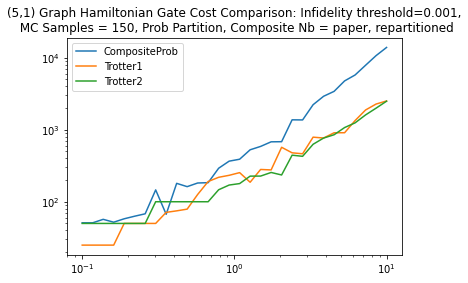

In [9]:

plt.title("(5,1) Graph Hamiltonian Gate Cost Comparison: Infidelity threshold=0.001,\n MC Samples = 150, Prob Partition, Composite Nb = paper, repartitioned")
plt.loglog(times, list(CompSim_results.values()), label="CompositeProb")
plt.loglog(times, list(TrotSim1_results.values()), label="Trotter1")
plt.loglog(times, list(TrotSim2_results.values()), label="Trotter2")
#plt.loglog(times, list(QDSim_results.values()), label="QDrift")
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

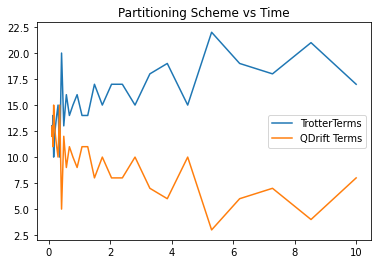

In [10]:
plt.title("Partitioning Scheme vs Time")
plt.plot(times, partition_dist[:,0], label="TrotterTerms")
plt.plot(times, partition_dist[:,1], label = "QDrift Terms")
#plt.plot(times, partition_dist[:,0]/partition_dist[:,1], label = "A/B ratio")
plt.legend()
plt.show

# Code Profiling

In [6]:
#Use the @profile decorator above any function in the notebook 
# and then simply execute the function from the classes defined below
QDtest = QDriftSim(graph_hamiltonian_list)
TrotTest = TrotterSim(graph_hamiltonian_list, order = 2)
CompTest = CompositeSim(graph_hamiltonian_list, inner_order =2, partition = "prob")

Nb is 28
There are 11 terms in Trotter
There are 5 terms in QDrift


In [9]:
CompTest.simulate(1, 40, 500)

         218970 function calls (218942 primitive calls) in 0.653 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.004    0.004    0.653    0.653 /Users/matthewpocrnic/Desktop/A1 Grad School Assignments/Master's Research/Simulation Code/Trotter-Qdrift-Simulation/compilers.py:709(simulate)
      500    0.066    0.000    0.584    0.001 /Users/matthewpocrnic/Desktop/A1 Grad School Assignments/Master's Research/Simulation Code/Trotter-Qdrift-Simulation/compilers.py:369(simulate)
      500    0.154    0.000    0.495    0.001 /Users/matthewpocrnic/Desktop/A1 Grad School Assignments/Master's Research/Simulation Code/Trotter-Qdrift-Simulation/compilers.py:355(draw_hamiltonian_samples)
    14500    0.013    0.000    0.331    0.000 <__array_function__ internals>:2(sum)
16206/16179    0.013    0.000    0.327    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    14500    0.030    0.000    0

array([[ 0.04657303+8.98447138e-03j],
       [-0.0081226 -1.05209938e-01j],
       [ 0.00043893+4.53157983e-03j],
       [ 0.0104241 -1.15266977e-02j],
       [-0.03289562+1.12467799e-01j],
       [ 0.26043223+4.73684174e-03j],
       [-0.01007516-1.15135397e-03j],
       [ 0.01950316+2.80811059e-02j],
       [ 0.05212141-1.40581937e-01j],
       [-0.3312342 -2.74534659e-02j],
       [ 0.01443539-5.90420141e-04j],
       [-0.03004891-3.93644517e-02j],
       [ 0.34153119+1.03827494e-01j],
       [ 0.02018393-7.92414014e-01j],
       [-0.00339412+2.90928113e-02j],
       [ 0.08686583-6.11311439e-02j]])